In [2]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [23]:
import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [4]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)      
        

In [5]:
conv = conv3x3(in_channels=32, out_channels=64)
print(conv)
del conv

Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


## Residual Block
To make clean code is mandatory to think about the main building block of each application, or of the network in our case. The residual block takes an input with `in_channels`, applies some blocks of convolutional layers to reduce it to `out_channels` and sum it up to the original input. If their sizes mismatch, then the input goes into an `identity`. We can abstract this process and create a interface that can be extedend.

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [7]:
ResidualBlock(32, 64)

ResidualBlock(
  (blocks): Identity()
  (shortcut): Identity()
)

In [8]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

Let's first create an handy function to stack one conv and batchnorm layer. Using `OrderedDict` to properly name each sublayer.

In [9]:
"""
from collections import OrderedDict
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))
"""

In [10]:
conv_bn(3, 3, nn.Conv2d, kernel_size=3)

Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [11]:
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
    

### BottleNeck
To increase the network deepths but to decrese the number of parameters, the Authors defined a BottleNeck block that 
"The three layers are 1x1, 3x3, and 1x1 convolutions, where the 1×1 layers are responsible for reducing and then increasing (restoring) dimensions, leaving the 3×3 layer a bottleneck with smaller input/output dimensions." We can extend the `ResNetResidualBlock` and create these blocks.

In [12]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
    

### Layer
A ResNet's layer is composed by blocks stacked one after the other. 

![alt](./images/custom/Layer.png)

We can easily defined it by just stuck `n` blocks one after the other, just remember that the first convolution block has a stide of two since "We perform downsampling directly by convolutional layers that have a stride of 2".

In [13]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

### Encoder
Similarly, the encoder is composed by multiple layer at increasing features size.

![alt](./images/custom/rotated-Encoder.png)



In [14]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

## Decoder
The decoder is the last piece we need to create the full network. It is a fully connected layer that maps the features learned by the network to their respective classes. Easily, we can defined it as:

In [15]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x


## ResNet

In [16]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
 
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

We can now defined the five models proposed by the Authors, `resnet18,34,50,101,152`

In [17]:
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

In [18]:
model = resnet50(3, 40)
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
        Conv2dAuto-7           [-1, 64, 56, 56]           4,096
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
       Conv2dAuto-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
       Conv2dAuto-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Image size
imagesize = 224

# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((imagesize, imagesize)),        # Resize image to target size
    transforms.ToTensor(),                            # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize image (ImageNet statistics)
])

val_transforms = transforms.Compose([
    transforms.Resize((imagesize, imagesize)),        # Resize image to target size
    transforms.ToTensor(),                            # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize image (ImageNet statistics)
])

# Define the directory path
datatrain_dir = '/kaggle/input/vgg-face-test-train/train_2/train_2'
dataval_dir = "/kaggle/input/vgg-face-test-train/test/test"
# Load the training and validation datasets
train_dataset = datasets.ImageFolder(
    root=datatrain_dir,
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root=dataval_dir,
    transform=val_transforms
)

# Create data loaders for training and validation
train_size = int(0.7 * len(train_dataset))  # 70% for training
test_size = len(train_dataset) - train_size  # 30% for testing
train_subset, test_subset = random_split(train_dataset, [train_size, test_size])

# Create data loaders for the subsets
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Example usage
for images, labels in train_loader:
    print(images.shape, labels.shape)  # Check the batch shape
    break


# TRAIN

In [45]:
model = resnet34(3, 40)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Common for classification tasks

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define history for visualization
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}


# Training loop
epochs = 20  
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit='batch'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss /= len(test_loader)
    val_acc = 100 * correct / total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

# Save the updated model
torch.save(model.state_dict(), "trained_model_continued.pth")

Epoch 1/20: 100%|██████████| 276/276 [01:10<00:00,  3.91batch/s]


Epoch [1/20], Loss: 3.3388, Accuracy: 12.17%
Validation Loss: 3.3125, Validation Accuracy: 13.83%


Epoch 2/20: 100%|██████████| 276/276 [01:11<00:00,  3.88batch/s]


Epoch [2/20], Loss: 2.7857, Accuracy: 21.22%
Validation Loss: 2.8687, Validation Accuracy: 21.67%


Epoch 3/20: 100%|██████████| 276/276 [01:11<00:00,  3.88batch/s]


Epoch [3/20], Loss: 2.4937, Accuracy: 28.26%
Validation Loss: 2.6249, Validation Accuracy: 23.62%


Epoch 4/20: 100%|██████████| 276/276 [01:10<00:00,  3.93batch/s]


Epoch [4/20], Loss: 2.2171, Accuracy: 35.92%
Validation Loss: 2.2978, Validation Accuracy: 33.41%


Epoch 5/20: 100%|██████████| 276/276 [01:10<00:00,  3.92batch/s]


Epoch [5/20], Loss: 2.0017, Accuracy: 41.82%
Validation Loss: 2.0847, Validation Accuracy: 40.62%


Epoch 6/20: 100%|██████████| 276/276 [01:09<00:00,  3.95batch/s]


Epoch [6/20], Loss: 1.7998, Accuracy: 47.67%
Validation Loss: 2.1320, Validation Accuracy: 40.71%


Epoch 7/20: 100%|██████████| 276/276 [01:10<00:00,  3.89batch/s]


Epoch [7/20], Loss: 1.6271, Accuracy: 51.79%
Validation Loss: 2.5650, Validation Accuracy: 40.16%


Epoch 8/20: 100%|██████████| 276/276 [01:10<00:00,  3.93batch/s]


Epoch [8/20], Loss: 1.4688, Accuracy: 56.16%
Validation Loss: 2.4158, Validation Accuracy: 39.17%


Epoch 9/20: 100%|██████████| 276/276 [01:10<00:00,  3.91batch/s]


Epoch [9/20], Loss: 1.3154, Accuracy: 60.61%
Validation Loss: 1.9952, Validation Accuracy: 46.19%


Epoch 10/20: 100%|██████████| 276/276 [01:10<00:00,  3.94batch/s]


Epoch [10/20], Loss: 1.1865, Accuracy: 64.23%
Validation Loss: 1.6261, Validation Accuracy: 55.26%


Epoch 11/20: 100%|██████████| 276/276 [01:10<00:00,  3.93batch/s]


Epoch [11/20], Loss: 1.0335, Accuracy: 68.68%
Validation Loss: 1.7661, Validation Accuracy: 52.86%


Epoch 12/20: 100%|██████████| 276/276 [01:10<00:00,  3.92batch/s]


Epoch [12/20], Loss: 0.9247, Accuracy: 71.82%
Validation Loss: 1.6722, Validation Accuracy: 55.94%


Epoch 13/20: 100%|██████████| 276/276 [01:10<00:00,  3.90batch/s]


Epoch [13/20], Loss: 0.7736, Accuracy: 76.23%
Validation Loss: 1.5876, Validation Accuracy: 58.61%


Epoch 14/20: 100%|██████████| 276/276 [01:10<00:00,  3.91batch/s]


Epoch [14/20], Loss: 0.6563, Accuracy: 79.59%
Validation Loss: 1.5632, Validation Accuracy: 60.29%


Epoch 15/20: 100%|██████████| 276/276 [01:10<00:00,  3.94batch/s]


Epoch [15/20], Loss: 0.5476, Accuracy: 82.55%
Validation Loss: 3.0766, Validation Accuracy: 38.44%


Epoch 16/20: 100%|██████████| 276/276 [01:10<00:00,  3.93batch/s]


Epoch [16/20], Loss: 0.4502, Accuracy: 85.59%
Validation Loss: 1.7403, Validation Accuracy: 59.47%


Epoch 17/20: 100%|██████████| 276/276 [01:10<00:00,  3.94batch/s]


Epoch [17/20], Loss: 0.3802, Accuracy: 87.43%
Validation Loss: 1.6091, Validation Accuracy: 62.15%


Epoch 18/20: 100%|██████████| 276/276 [01:10<00:00,  3.92batch/s]


Epoch [18/20], Loss: 0.3086, Accuracy: 89.78%
Validation Loss: 1.7677, Validation Accuracy: 59.97%


Epoch 19/20: 100%|██████████| 276/276 [01:10<00:00,  3.92batch/s]


Epoch [19/20], Loss: 0.2488, Accuracy: 92.08%
Validation Loss: 1.7248, Validation Accuracy: 63.78%


Epoch 20/20: 100%|██████████| 276/276 [01:10<00:00,  3.93batch/s]


Epoch [20/20], Loss: 0.2018, Accuracy: 93.46%
Validation Loss: 2.0487, Validation Accuracy: 59.56%


In [43]:
model = resnet50(3, 40)  # Make sure you define the model architecture as it was before


model.load_state_dict(torch.load("trained_model_continued.pth"))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
'''
# Define history for visualization
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}
'''

# Training loop
starting_epoch = 15  
epochs = 25  

# Training and Validation loop
for epoch in range(starting_epoch, epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0


    # Training loop
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit='batch'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss /= len(test_loader)
    val_acc = 100 * correct / total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

# Save the updated model
torch.save(model.state_dict(), "trained_model.pth")

/tmp/ipykernel_23/2092249739.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_model_continued.pth"))
Epoch 16/25: 100%|█████████

Epoch [16/25], Loss: 1.6192, Accuracy: 52.50%
Validation Loss: 4.0659, Validation Accuracy: 22.12%


Epoch 17/25: 100%|██████████| 276/276 [01:54<00:00,  2.41batch/s]


Epoch [17/25], Loss: 1.3362, Accuracy: 60.42%
Validation Loss: 2.3564, Validation Accuracy: 38.53%


Epoch 18/25: 100%|██████████| 276/276 [01:53<00:00,  2.42batch/s]


Epoch [18/25], Loss: 1.0960, Accuracy: 66.56%
Validation Loss: 2.3437, Validation Accuracy: 45.24%


Epoch 19/25: 100%|██████████| 276/276 [01:53<00:00,  2.43batch/s]


Epoch [19/25], Loss: 0.9449, Accuracy: 70.29%
Validation Loss: 1.7029, Validation Accuracy: 54.17%


Epoch 20/25: 100%|██████████| 276/276 [01:54<00:00,  2.41batch/s]


Epoch [20/25], Loss: 0.7806, Accuracy: 75.10%
Validation Loss: 1.9915, Validation Accuracy: 51.22%


Epoch 21/25: 100%|██████████| 276/276 [01:53<00:00,  2.44batch/s]


Epoch [21/25], Loss: 0.5995, Accuracy: 81.26%
Validation Loss: 1.9713, Validation Accuracy: 52.95%


Epoch 22/25: 100%|██████████| 276/276 [01:53<00:00,  2.44batch/s]


Epoch [22/25], Loss: 0.5054, Accuracy: 83.32%
Validation Loss: 3.0616, Validation Accuracy: 39.85%


Epoch 23/25: 100%|██████████| 276/276 [01:53<00:00,  2.44batch/s]


Epoch [23/25], Loss: 0.3873, Accuracy: 87.43%
Validation Loss: 2.0207, Validation Accuracy: 56.94%


Epoch 24/25: 100%|██████████| 276/276 [01:53<00:00,  2.43batch/s]


Epoch [24/25], Loss: 0.3025, Accuracy: 90.13%
Validation Loss: 2.0712, Validation Accuracy: 57.71%


Epoch 25/25: 100%|██████████| 276/276 [01:53<00:00,  2.43batch/s]


Epoch [25/25], Loss: 0.2762, Accuracy: 90.93%
Validation Loss: 3.4358, Validation Accuracy: 47.14%


# Visualization

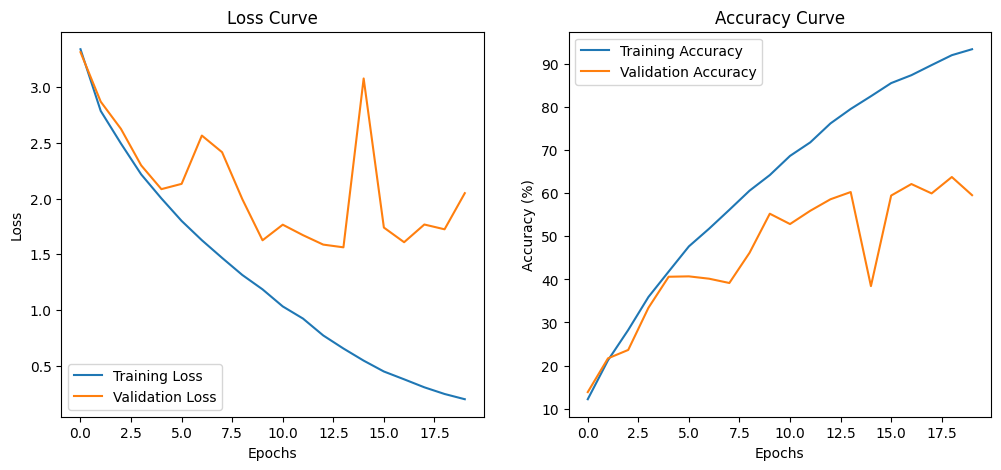

Precision: 0.66, Recall: 0.59, F1-Score: 0.59


In [52]:
# Visualization: Loss and Accuracy curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(0, epochs), history['train_loss'], label='Training Loss')
plt.plot(range(0, epochs), history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(0, epochs), history['train_acc'], label='Training Accuracy')
plt.plot(range(0, epochs), history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()



# Precision, Recall, F-Score
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}")

# ROC and AUC (if binary classification, extendable to multi-class with one-vs-all)
if len(np.unique(all_labels)) == 2:
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Save history (optional)
np.save('training_history.npy', history)


# Precision, Recall, F-score

In [53]:

# Generate classification report
report = classification_report(y_true, y_pred, target_names=train_dataset.classes)
print(report)


NameError: name 'y_true' is not defined

# Confusion Matrix

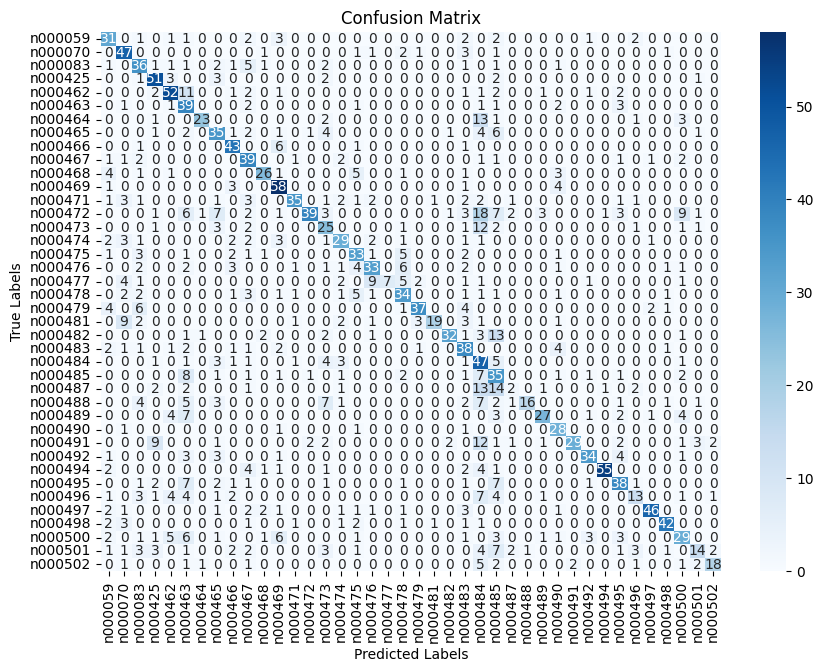

In [54]:
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
